# Dataset prep 

Here the dataset is extracted and preprocessed to be used for training. This notebook includes. 

- Downloading of the dataset
- Removal of outlier samples from the dataset
- Segmenting raw background noise into 1s files to be used as a the non-target voice command
- Resolving class imbalance 


### Imports

In [4]:
#imports from public libraries
import os
from pyroomacoustics.datasets.google_speech_commands import GoogleSpeechCommands
from joblib import Parallel, delayed
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#imports from modules
from voice_power_package.utils import list_subfolders,get_files
from voice_power_package.data_preprocessing import process_background,FilterAudioData,SplitDataset

### Constants

In [7]:
NOISE_FLOOR=0.1
REQUIRED_LENGTH=4000
EXPECTED_SAMPLES=16000

DATASET_PATH="audio_data"
RAW_BACKGROUND="_background_noise_"
CLASS_BACKGROUND="background"
TARGET_WORD='marvin'

SEED= 324234
TARGET_RATIO=0.5
BACKGROUND_RATIO=0.1
train_ratio,val_ratio,test_ratio=0.8,0.1,0.1

raw_backgound_path=os.path.join(DATASET_PATH,RAW_BACKGROUND)
class_background_path=os.path.join(DATASET_PATH,CLASS_BACKGROUND)

## Downloading dataset

The Speech Commands Dataset has 65,000 one-second long utterances of 30 short words, by thousands of different people, contributed by members of the public through the AIY website. It’s released under a Creative Commons BY 4.0 license.

In [ ]:
GoogleSpeechCommands(DATASET_PATH,download=False)

## Removing outlier samples

This involves:

- removing samples that are not 1s in length (16000 samples)
- removing samples with voice lenghts less than 0.25s

In [23]:
words = list_subfolders(DATASET_PATH)
classes=[word for word in words if "_" not in word]

filter_data=FilterAudioData(data_folder=DATASET_PATH,
                            noise_floor=NOISE_FLOOR,
                            required_length=REQUIRED_LENGTH,
                            expected_samples=EXPECTED_SAMPLES)

valid_file_names=Parallel(n_jobs=-1)(delayed(filter_data.get_valid_audio)(word) for word in classes)

## Creating background noise class

In [24]:
os.makedirs(class_background_path,exist_ok=True)

background_files=[f.path for f in os.scandir(raw_backgound_path) if "wav" in f.path]
for file in background_files:
    process_background(file,class_background_path)

valid_file_names.append(get_files(CLASS_BACKGROUND,DATASET_PATH))
classes.append(CLASS_BACKGROUND)

valid_dict={word:files for word,files in zip(classes,valid_file_names)}

#saving valid dict 
f = open("valid_filenames.pkl","wb")
pickle.dump(valid_dict,f)
f.close()

c:\Users\abdul\OneDrive\Documents\university\4th year\term2\ENGR 501\501_project\data\voice_power\modules\data_preprocessing.py:439: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, audio = scipy.io.wavfile.read(background_file_path)


## Examining data distribution 

In [3]:
#loading the valid file dictionary 
with open('../valid_filenames.pkl', 'rb') as handle:
    dict_filenames=pickle.load(handle)

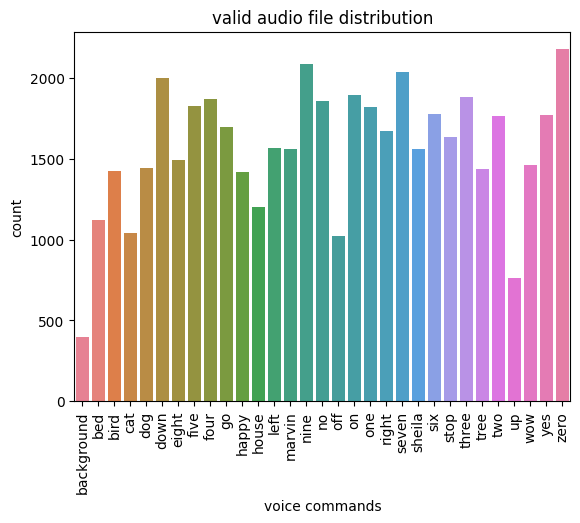

In [5]:
num_files=[len(files) for files in dict_filenames.values()]
keys=list(dict_filenames.keys())
#plt.bar(keys,height=num_files)
sns.barplot(x=keys,y=num_files,hue=keys)
plt.xticks(rotation='vertical')
plt.ylabel('count')
plt.xlabel('voice commands')
plt.title('valid audio file distribution')
plt.show()

## Splitting data to train, val and test

In [8]:
split=SplitDataset(dict_filenames=dict_filenames,
                   target_class=TARGET_WORD,
                   background_class=CLASS_BACKGROUND, 
                   target_ratio=TARGET_RATIO, 
                   background_ratio=BACKGROUND_RATIO, 
                   train_ratio=train_ratio, 
                   val_ratio=val_ratio, 
                   test_ratio=test_ratio,
                   shuffle=True,
                   seed=SEED)

dict_split=split.split()

train_sizes=[len(files) for files in dict_split['train']]
val_sizes=[len(files) for files in dict_split['val']]
test_sizes=[len(files) for files in dict_split['test']]

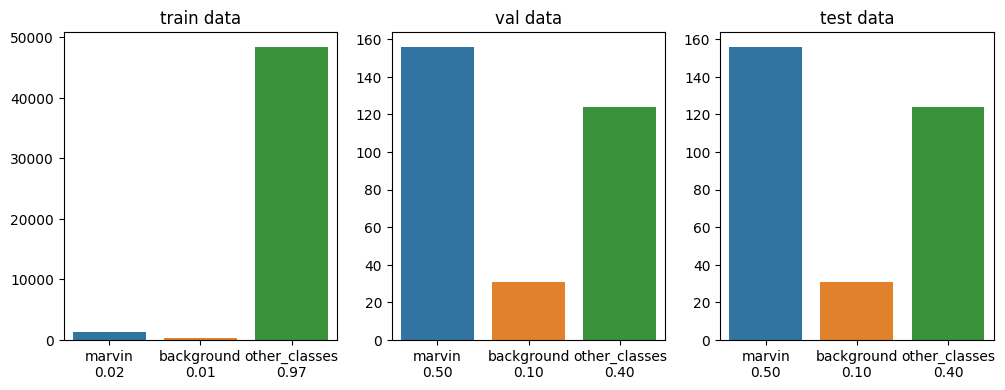

In [9]:
str_data=['marvin','background','other_classes']

def plot_data_dist(ax,split_sizes,title):
    perc=np.array(split_sizes)/sum(split_sizes)
    str_xticks=[f'{word}\n{per:.2f}' for word,per in zip(str_data,perc)]
    
    sns.barplot(x=str_xticks,y=split_sizes,hue=str_xticks,ax=ax)
    ax.set_title(title)

fig,axes=plt.subplots(1,3,figsize=(12,4))
plot_splits=[train_sizes,val_sizes,test_sizes]
titles=['train data','val data','test data']
for ax,split_sizes,title in zip(axes,plot_splits,titles):
    plot_data_dist(ax,split_sizes,title)

The data distribution for the testting and validation set is 0.5, 0.1, 0.4 for the marvin, background and other_classes respectively. This distribution will be maintained at every epoch for the training set by performing dynamic downsampling. Since "other_classes" is the majority class, it will be randomly downsampled without replacement at every epoch such that it makes up 0.4 of the training dataset. 

This randomized downsampling ensures that the machine learning models gets exposed with a wide variety of voice commands that do not correspond to the "marvin" target word. Combined with data augmentation with the custom datagenerator class, will result in regularization that aids the model to generalize to a wide variety of audio samples.

In [10]:
#saving dict_split 
f = open("../data/dict_split.pkl","wb")
pickle.dump(dict_split,f)
f.close()